In [3]:
# PGD Attack and Defend on ResNet50
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import Subset
import random

num_epochs = 10
batch_size = 128
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_indices = random.sample(range(len(train_dataset)), len(train_dataset))
test_indices = random.sample(range(len(test_dataset)), len(test_dataset))

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

model = resnet50(num_classes=10).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

In [4]:
# Train Model on clean Dataset
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/10], Step [100/469], Loss: 0.6346
Epoch [1/10], Step [200/469], Loss: 0.4900
Epoch [1/10], Step [300/469], Loss: 0.3956
Epoch [1/10], Step [400/469], Loss: 0.3002
Epoch [2/10], Step [100/469], Loss: 0.4191
Epoch [2/10], Step [200/469], Loss: 0.3383
Epoch [2/10], Step [300/469], Loss: 0.4023
Epoch [2/10], Step [400/469], Loss: 0.3026
Epoch [3/10], Step [100/469], Loss: 0.2975
Epoch [3/10], Step [200/469], Loss: 0.4985
Epoch [3/10], Step [300/469], Loss: 0.3040
Epoch [3/10], Step [400/469], Loss: 0.3218
Epoch [4/10], Step [100/469], Loss: 0.2290
Epoch [4/10], Step [200/469], Loss: 0.2229
Epoch [4/10], Step [300/469], Loss: 0.2210
Epoch [4/10], Step [400/469], Loss: 0.2302
Epoch [5/10], Step [100/469], Loss: 0.3149
Epoch [5/10], Step [200/469], Loss: 0.1490
Epoch [5/10], Step [300/469], Loss: 0.2421
Epoch [5/10], Step [400/469], Loss: 0.2574
Epoch [6/10], Step [100/469], Loss: 0.2968
Epoch [6/10], Step [200/469], Loss: 0.3300
Epoch [6/10], Step [300/469], Loss: 0.1755
Epoch [6/10

In [5]:
# Test on clean Dataset
def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')


Accuracy on the clean test set: 90.60%


test acc 22.65625%
test acc 17.1875%
test acc 14.0625%
test acc 10.9375%
test acc 10.9375%
test acc 10.9375%
test acc 10.9375%
test acc 10.9375%
test acc 10.9375%
test acc 10.9375%


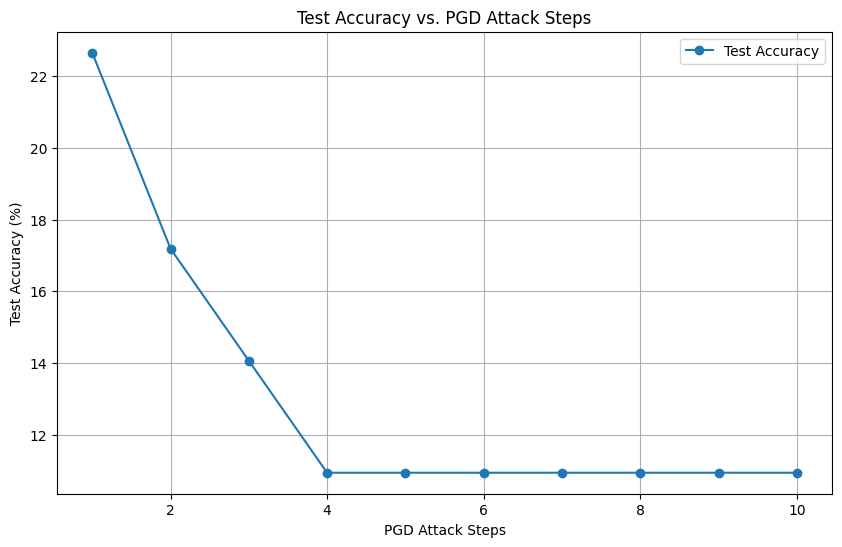

In [8]:
# PGD Attack

import matplotlib.pyplot as plt

def pgd_attack(model, images, labels, eps, alpha, iters):
    adv_images = images.clone().detach()
    original_images = images.clone().detach()
    all_adv_images = []  

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        model.zero_grad()
        loss.backward()
        adv_images = adv_images + alpha * adv_images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        adv_images = torch.clamp(original_images + eta, min=0, max=1).detach()
        
        all_adv_images.append(adv_images.clone().detach())  

    return adv_images, all_adv_images

eps = 0.03
alpha = 0.007
iters = 10
step_accuracies = []

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    _, all_adv_images = pgd_attack(model, images, labels, eps, alpha, iters)
    
    for adv_images in all_adv_images:
        acc = test_model([(adv_images, labels)])
        print(f"test acc {acc}%")
        step_accuracies.append(acc)
    break  

plt.figure(figsize=(10, 6))
plt.plot(range(1, iters + 1), step_accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy vs. PGD Attack Steps')
plt.xlabel('PGD Attack Steps')
plt.ylabel('Test Accuracy (%)')
plt.grid()
plt.legend()
plt.show()

In [10]:
# Defend against PGD

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        adv_images,_ = pgd_attack(model, images, labels, eps, alpha, iters)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')
print(f'Accuracy on adversarial examples after adversarial retraining: {test_model([(adv_images, labels)]):.2f}%')


Epoch [1/10], Step [100/469], Loss: 0.5304
Epoch [1/10], Step [200/469], Loss: 0.3995
Epoch [1/10], Step [300/469], Loss: 0.3534
Epoch [1/10], Step [400/469], Loss: 0.3546
Epoch [2/10], Step [100/469], Loss: 0.2999
Epoch [2/10], Step [200/469], Loss: 0.2825
Epoch [2/10], Step [300/469], Loss: 0.3270
Epoch [2/10], Step [400/469], Loss: 0.4116
Epoch [3/10], Step [100/469], Loss: 0.2227
Epoch [3/10], Step [200/469], Loss: 0.2749
Epoch [3/10], Step [300/469], Loss: 0.3433
Epoch [3/10], Step [400/469], Loss: 0.3951
Epoch [4/10], Step [100/469], Loss: 0.2719
Epoch [4/10], Step [200/469], Loss: 0.2850
Epoch [4/10], Step [300/469], Loss: 0.2961
Epoch [4/10], Step [400/469], Loss: 0.3450
Epoch [5/10], Step [100/469], Loss: 0.2862
Epoch [5/10], Step [200/469], Loss: 0.2883
Epoch [5/10], Step [300/469], Loss: 0.2316
Epoch [5/10], Step [400/469], Loss: 0.3808
Epoch [6/10], Step [100/469], Loss: 0.2946
Epoch [6/10], Step [200/469], Loss: 0.2570
Epoch [6/10], Step [300/469], Loss: 0.3744
Epoch [6/10